(Ex1)(2)

In [1]:
import numpy as np

def generate_discrete_rv(p, x_vals):
    """
    Generate a discrete random variable X using the inversion method.

    Parameters:
        p (list): Probabilities of the discrete distribution.
        x_vals (list): Corresponding values of X.

    Returns:
        float: A single sample from the discrete distribution.
    """
    # Compute cumulative distribution function (CDF)
    cdf = np.cumsum(p)
    
    # Sample U from Unif([0, 1])
    u = np.random.uniform(0, 1)
    
    # Find the smallest k where cdf[k] >= u
    for k in range(len(cdf)):
        if cdf[k] >= u:
            return x_vals[k]

# Example of 10 iteration just to see the frequency of appearance of x_k
p = [0.4, 0.1, 0.1, 0.4]  # Probabilities
x_vals = [1, 2, 3, 4]      # Corresponding X values
for i in range(10):
    sample = generate_discrete_rv(p, x_vals)
    print("Generated sample:", sample," ")

Generated sample: 1  
Generated sample: 4  
Generated sample: 1  
Generated sample: 4  
Generated sample: 1  
Generated sample: 1  
Generated sample: 1  
Generated sample: 4  
Generated sample: 2  
Generated sample: 2  


(Ex1)(3)

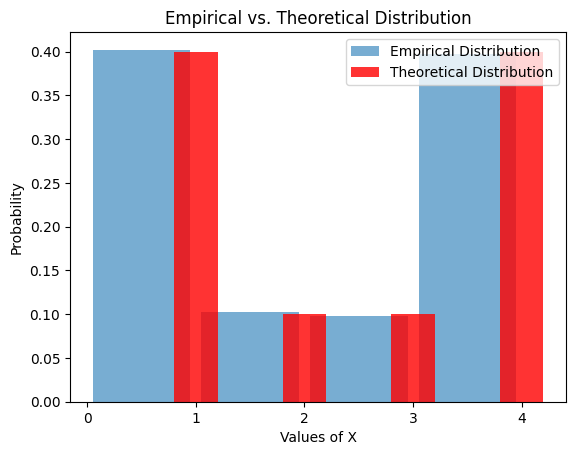

In [2]:
import matplotlib.pyplot as plt

def simulate_discrete_rv(p, x_vals, N):
    """
    Simulate N samples from a discrete random variable and compare distributions.

    Parameters:
        p (list): Probabilities of the discrete distribution.
        x_vals (list): Corresponding values of X.
        N (int): Number of samples to generate.

    Returns:
        None: Displays a histogram of the empirical distribution vs. theoretical.
    """
    samples = [generate_discrete_rv(p, x_vals) for _ in range(N)]
    
    # Empirical histogram
    counts, bins = np.histogram(samples, bins=np.arange(min(x_vals)-0.5, max(x_vals)+1.5, 1), density=True)
    
    # Plot
    plt.bar(bins[:-1], counts, width=0.9, alpha=0.6, label="Empirical Distribution", align="center")
    plt.bar(x_vals, p, width=0.4, alpha=0.8, label="Theoretical Distribution", color='red')
    plt.xlabel("Values of X")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("Empirical vs. Theoretical Distribution")
    plt.show()

# Example usage
simulate_discrete_rv(p, x_vals, N=10000)

(Ex2)(2&3)

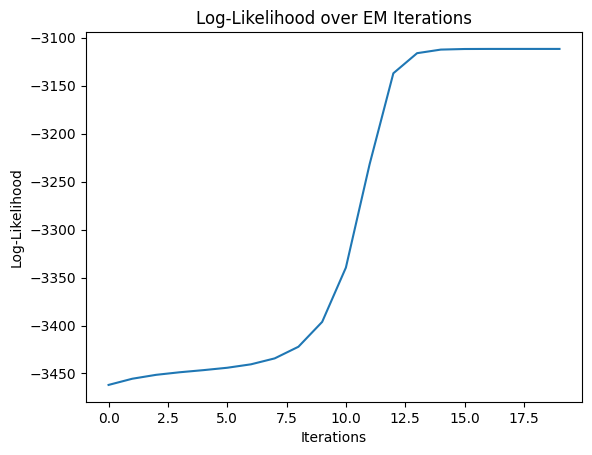


Comparison of Parameters:
------------------------------
Weights:
  Component 1: True = 0.4000, Estimated = 0.4011, Difference = 0.0011
  Component 2: True = 0.6000, Estimated = 0.5989, Difference = 0.0011

Means:
  Component 1: True = [0 0], Estimated = [-0.01225597 -0.00745086], Difference (L2 norm) = 0.0143
  Component 2: True = [3 3], Estimated = [3.01222867 3.00612106], Difference (L2 norm) = 0.0137

Covariances:
  Component 1: True = 
[[1. 0.]
 [0. 1.]], 
Estimated = 
[[1.07045367 0.03880994]
 [0.03880994 1.02160293]], 
Difference (L2 norm) = 0.0919
  Component 2: True = 
[[0.5 0. ]
 [0.  0.5]], 
Estimated = 
[[0.50786659 0.02433746]
 [0.02433746 0.51547687]], 
Difference (L2 norm) = 0.0385


In [4]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# 1. Generate synthetic data for GMM (Question 2)
def generate_data(n, weights, means, covariances):
    """
    Generate data from a Gaussian Mixture Model.

    Parameters:
        n (int): Total number of samples.
        weights (list): Mixing weights of the GMM.
        means (list): Means of the Gaussian components.
        covariances (list): Covariance matrices of the Gaussian components.

    Returns:
        X (ndarray): Generated data points.
        labels (ndarray): True labels for the components.
    """
    X = []
    labels = []
    for j, weight in enumerate(weights):
        count = int(weight * n)
        X.append(np.random.multivariate_normal(means[j], covariances[j], count))
        labels.append(np.full(count, j))
    return np.vstack(X), np.concatenate(labels)

# 2. Initialization of GMM parameters
def initialize_gmm(X, num_clusters):
    """
    Initialize parameters for the GMM.
    """
    n, d = X.shape
    weights = np.ones(num_clusters) / num_clusters
    means = X[np.random.choice(n, num_clusters, replace=False)]
    covariances = [np.cov(X, rowvar=False)] * num_clusters
    return weights, means, covariances

# 3. E-Step: Compute posterior probabilities
def e_step(X, weights, means, covariances):
    """
    Perform the E-step of the EM algorithm.
    """
    n, num_clusters = len(X), len(weights)
    posteriors = np.zeros((n, num_clusters))
    for j in range(num_clusters):
        posteriors[:, j] = weights[j] * multivariate_normal.pdf(X, means[j], covariances[j])
    posteriors /= posteriors.sum(axis=1, keepdims=True)
    return posteriors

# 4. M-Step: Update parameters
def m_step(X, posteriors):
    """
    Perform the M-step of the EM algorithm.
    """
    n, d = X.shape
    num_clusters = posteriors.shape[1]
    weights = posteriors.sum(axis=0) / n
    means = np.dot(posteriors.T, X) / posteriors.sum(axis=0)[:, None]
    covariances = []
    for j in range(num_clusters):
        diff = X - means[j]
        covariances.append(np.dot(posteriors[:, j] * diff.T, diff) / posteriors[:, j].sum())
    return weights, means, covariances

# 5. Log-Likelihood
def log_likelihood(X, weights, means, covariances):
    """
    Compute the log-likelihood of the data under the GMM model.
    """
    ll = 0
    for j in range(len(weights)):
        ll += weights[j] * multivariate_normal.pdf(X, means[j], covariances[j])
    return np.log(ll).sum()

# 6. EM Algorithm
def em_algorithm(X, num_clusters, max_iters=100, tol=1e-4):
    """
    Perform the EM algorithm to fit a GMM.
    """
    weights, means, covariances = initialize_gmm(X, num_clusters)
    log_likelihoods = []
    for _ in range(max_iters):
        posteriors = e_step(X, weights, means, covariances)
        weights, means, covariances = m_step(X, posteriors)
        ll = log_likelihood(X, weights, means, covariances)
        log_likelihoods.append(ll)
        if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    return weights, means, covariances, log_likelihoods

# 7. Compare the estimated parameters to the original ones (Question 4)
def compare_parameters(weights_true, weights_est, means_true, means_est, covariances_true, covariances_est):
    """
    Compare the estimated parameters to the true parameters.
    """
    print("\nComparison of Parameters:")
    print("-" * 30)
    
    # Compare weights
    print("Weights:")
    for i, (w_true, w_est) in enumerate(zip(weights_true, weights_est)):
        print(f"  Component {i + 1}: True = {w_true:.4f}, Estimated = {w_est:.4f}, Difference = {abs(w_true - w_est):.4f}")
    
    # Compare means
    print("\nMeans:")
    for i, (m_true, m_est) in enumerate(zip(means_true, means_est)):
        diff = np.linalg.norm(m_true - m_est)
        print(f"  Component {i + 1}: True = {m_true}, Estimated = {m_est}, Difference (L2 norm) = {diff:.4f}")
    
    # Compare covariances
    print("\nCovariances:")
    for i, (cov_true, cov_est) in enumerate(zip(covariances_true, covariances_est)):
        diff = np.linalg.norm(cov_true - cov_est)
        print(f"  Component {i + 1}: True = \n{cov_true}, \nEstimated = \n{cov_est}, \nDifference (L2 norm) = {diff:.4f}")

# 8. Example Usage (for questions 2, 3, and 4)
if __name__ == "__main__":
    # True parameters
    weights_true = [0.4, 0.6]
    means_true = [np.array([0, 0]), np.array([3, 3])]
    covariances_true = [np.eye(2), np.eye(2) * 0.5]
    
    # Generate data
    n_samples = 1000
    X, labels = generate_data(n_samples, weights_true, means_true, covariances_true)
    
    # Run EM algorithm
    num_clusters = len(weights_true)
    weights_est, means_est, covariances_est, log_likelihoods = em_algorithm(X, num_clusters)
    
    # Plot log-likelihood
    plt.plot(log_likelihoods)
    plt.xlabel("Iterations")
    plt.ylabel("Log-Likelihood")
    plt.title("Log-Likelihood over EM Iterations")
    plt.show()
    
    # Compare estimated and true parameters
    compare_parameters(weights_true, weights_est, means_true, means_est, covariances_true, covariances_est)


(EX2)(4&5&6)

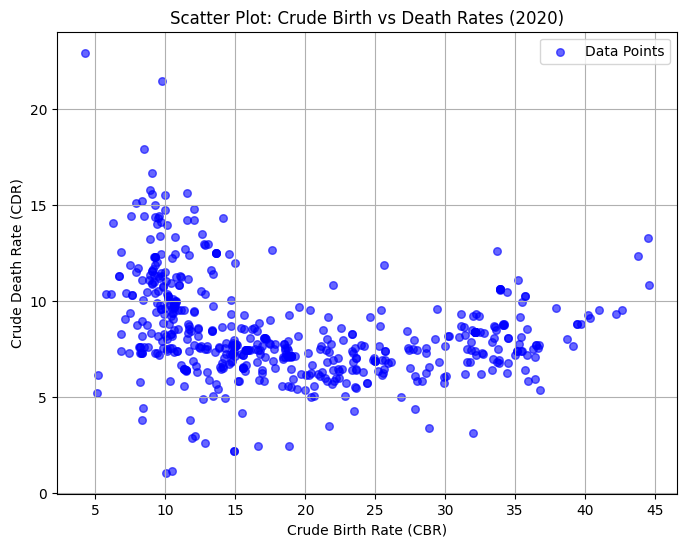

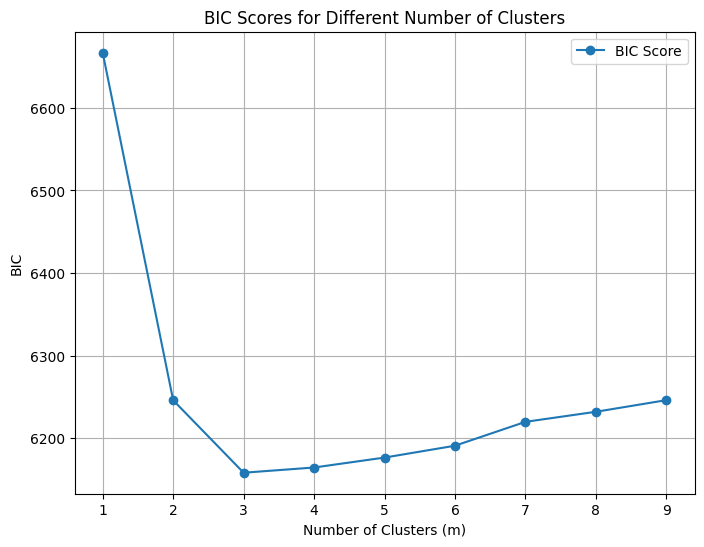

Optimal number of clusters (m) based on BIC: 3


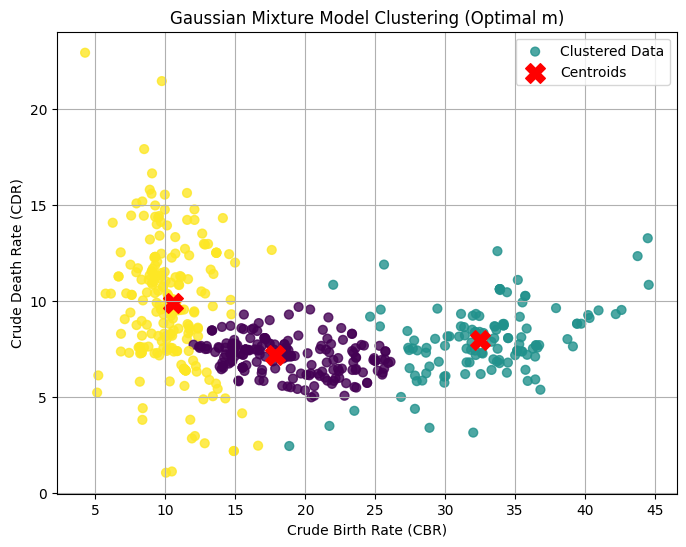

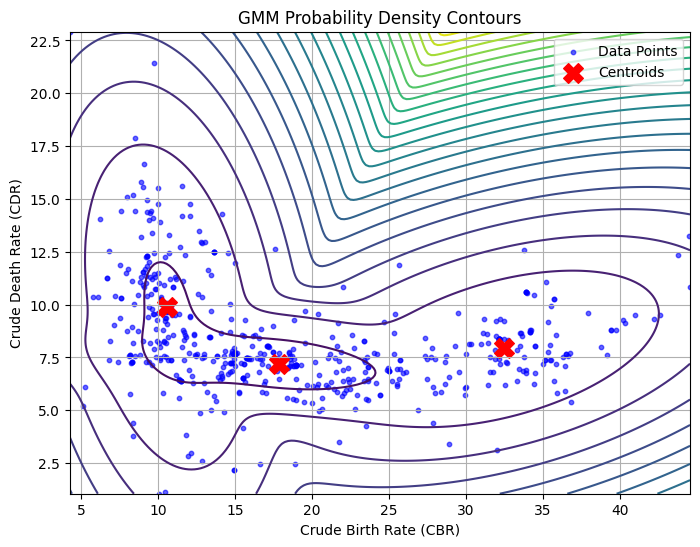

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# File name
file_name = "data.csv"

# Load the dataset
data = pd.read_csv(file_name, low_memory=False)

# Filter data for the year 2020
year_col = "Time"
birth_rate_col = "CBR"  # Crude Birth Rate
death_rate_col = "CDR"  # Crude Death Rate

# Convert relevant columns to numeric
data[year_col] = pd.to_numeric(data[year_col], errors="coerce")
data[birth_rate_col] = pd.to_numeric(data[birth_rate_col], errors="coerce")
data[death_rate_col] = pd.to_numeric(data[death_rate_col], errors="coerce")

# Filter for the year 2020
filtered_data = data[data[year_col] == 2020].dropna(subset=[birth_rate_col, death_rate_col])

# Prepare data for GMM
X = filtered_data[[birth_rate_col, death_rate_col]].values

# Scatter plot of Crude Birth Rate vs. Death Rate
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=30, c='blue', alpha=0.6, label='Data Points')
plt.title('Scatter Plot: Crude Birth vs Death Rates (2020)')
plt.xlabel('Crude Birth Rate (CBR)')
plt.ylabel('Crude Death Rate (CDR)')
plt.legend()
plt.grid(True)
plt.show()

# Fit GMMs for different numbers of clusters and compute BIC
bic_scores = []
n_clusters = range(1, 10)
gmm_models = []

for m in n_clusters:
    gmm = GaussianMixture(n_components=m, random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    gmm_models.append(gmm)

# Plot the BIC scores
plt.figure(figsize=(8, 6))
plt.plot(n_clusters, bic_scores, marker='o', label='BIC Score')
plt.title('BIC Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters (m)')
plt.ylabel('BIC')
plt.xticks(n_clusters)
plt.grid(True)
plt.legend()
plt.show()

# Find the optimal number of clusters
optimal_m = n_clusters[np.argmin(bic_scores)]
print(f"Optimal number of clusters (m) based on BIC: {optimal_m}")

# Fit the optimal GMM and plot the results
optimal_gmm = gmm_models[np.argmin(bic_scores)]
labels = optimal_gmm.predict(X)
probs = optimal_gmm.predict_proba(X)
centers = optimal_gmm.means_

# Scatter plot with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=40, alpha=0.8, label='Clustered Data')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('Gaussian Mixture Model Clustering (Optimal m)')
plt.xlabel('Crude Birth Rate (CBR)')
plt.ylabel('Crude Death Rate (CDR)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the p.d.f using contours
x = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
y = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
Z = -optimal_gmm.score_samples(XX)
Z = Z.reshape(X_grid.shape)

plt.figure(figsize=(8, 6))
plt.contour(X_grid, Y_grid, Z, levels=20, cmap="viridis")
plt.scatter(X[:, 0], X[:, 1], s=10, c='blue', alpha=0.6, label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('GMM Probability Density Contours')
plt.xlabel('Crude Birth Rate (CBR)')
plt.ylabel('Crude Death Rate (CDR)')
plt.legend()
plt.grid(True)
plt.show()


Results with mu=0.8:
N=10: Estimate=0.5453, Variance=0.3380, Weights in [0.6258,1.4089]
N=100: Estimate=0.7994, Variance=0.0255, Weights in [0.1786,1.3235]
N=1000: Estimate=0.8073, Variance=0.0025, Weights in [0.0111,1.4011]
N=10000: Estimate=0.8228, Variance=0.0003, Weights in [0.0002,1.4052]
Results with mu=6:
N=10: Estimate=-0.8250, Weights in [0.0002,1.4052]
N=100: Estimate=-0.1370, Weights in [0.0002,1.4052]
N=1000: Estimate=-1.5387, Weights in [0.0002,1.4052]
N=10000: Estimate=0.9321, Weights in [0.0002,1.4052]


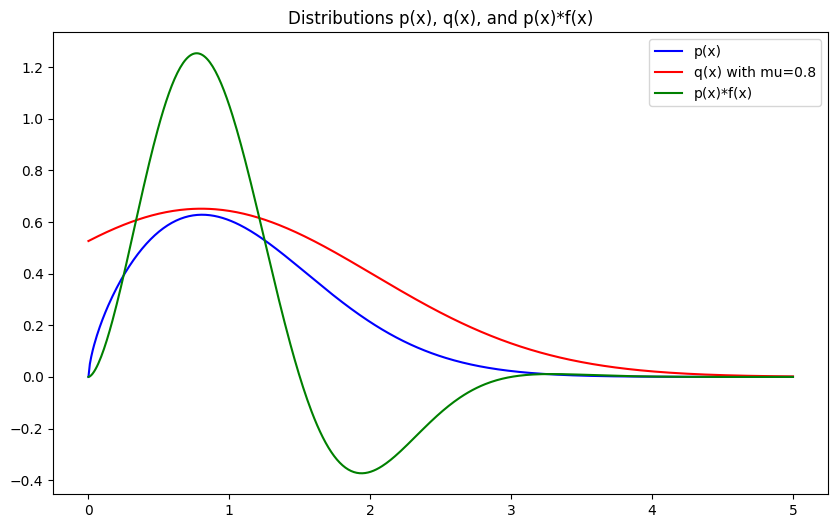

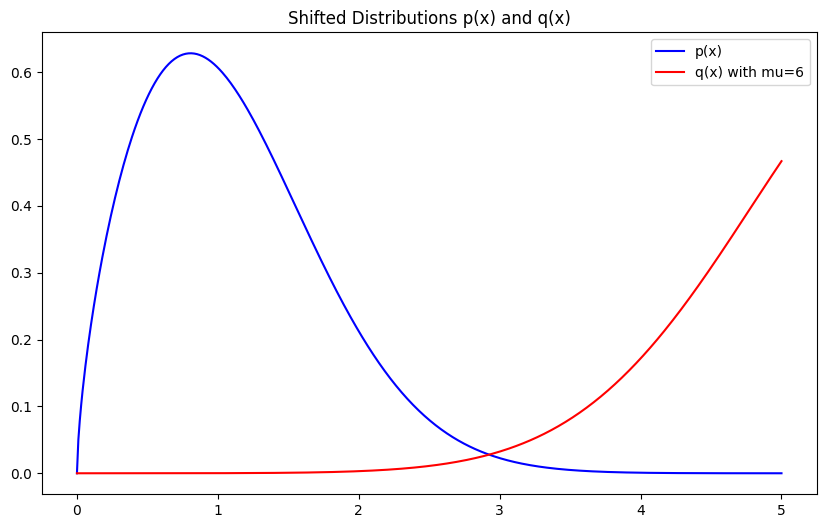

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define p(x) and q(x)
def p(x):
    return (x **(0.65) )* np.exp(-x**2 / 2) * (x > 0)

def q(x, mu=0.8, sigma=1.5):
    return 2*norm.pdf(x, loc=mu, scale=np.sqrt(sigma))

# Define the function f(x)
def f(x):
    return 2 * np.sin(np.pi * x / 1.5) * (x > 0)

# Importance sampling procedure
def importance_sampling(mu, N):
    samples_q = np.random.normal(loc=mu, scale=np.sqrt(1.5), size=N)
    samples_q = samples_q[samples_q > 0]  # Discard negative samples
    weights = p(samples_q) / q(samples_q, mu=mu)
    weights=weights/np.mean(weights) # Normalize !!!
    estimate = np.mean(f(samples_q) * weights)
    variance = np.var(f(samples_q) * weights) / samples_q.shape[0]
    return estimate, variance, samples_q, weights

# Experiment 1: Importance Sampling with mu=0.8
N_values = [10**i for i in range(1,5)]
results = [importance_sampling(mu=0.8, N=N) for N in N_values]
print("Results with mu=0.8:")
for N, (est, var, _, w) in zip(N_values, results):
    print(f"N={N}: Estimate={est:.4f}, Variance={var:.4f}, Weights in [{np.min(w):.4f},{np.max(w):.4f}]")

# Experiment 2: Importance Sampling with shifted mu=6
results_shifted = [importance_sampling(mu=6, N=N) for N in N_values]
print("Results with mu=6:")
for N, (est, var, _, _) in zip(N_values, results_shifted):
    print(f"N={N}: Estimate={est:.4f}, Weights in [{np.min(w):.4f},{np.max(w):.4f}]")

# Visualization of distributions p(x), q(x), and p(x)*f(x)
x = np.linspace(0, 5, 500)
plt.figure(figsize=(10, 6))
plt.plot(x, p(x), label="p(x)", color="blue")
plt.plot(x, q(x, mu=0.8), label="q(x) with mu=0.8", color="red")
plt.plot(x, f(x) * p(x), label="p(x)*f(x)", color="green")
plt.title("Distributions p(x), q(x), and p(x)*f(x)")
plt.legend()
plt.savefig("p_q_distributions.png")
plt.show()

# Shifted distributions
plt.figure(figsize=(10, 6))
plt.plot(x, p(x), label="p(x)", color="blue")
plt.plot(x, q(x, mu=6), label="q(x) with mu=6", color="red")
plt.title("Shifted Distributions p(x) and q(x)")
plt.legend()
plt.savefig("shifted_distributions.png")
plt.show()


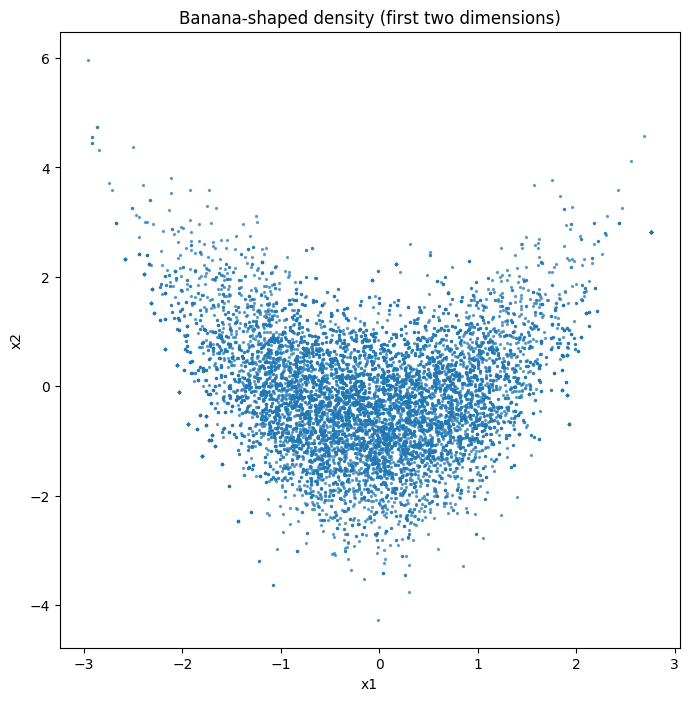

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Parameters for the banana-shaped density
d = 5
b = 0.4
sigma1 = 1
num_samples = 1000
iterations = 10

# Function to transform samples to the banana-shaped density
def banana_density_transform(samples):
    x1 = samples[:, 0]
    x2 = samples[:, 1] + b * (x1**2 - sigma1)
    transformed = samples.copy()
    transformed[:, 1] = x2
    return transformed

# Initialize proposal distribution
proposal_mean = np.zeros(d)
proposal_cov = np.eye(d)

adaptive_samples = []

for iteration in range(iterations):
    # Step 1: Sample from the current proposal distribution
    if iteration == 0:
        # Initial proposal is a single Gaussian
        samples = np.random.multivariate_normal(mean=proposal_mean, cov=proposal_cov, size=num_samples)
    else:
        # Sample from the GMM
        component_indices = np.random.choice(len(proposal_weights), size=num_samples, p=proposal_weights)
        samples = np.array([
            np.random.multivariate_normal(proposal_mean[k], proposal_cov[k])
            for k in component_indices
        ])
    
    # Step 2: Apply the banana density transformation
    transformed_samples = banana_density_transform(samples)
    
    # Step 3: Compute importance weights
    weights = np.exp(
        -0.5 * np.sum((transformed_samples / sigma1)**2, axis=1)  # Target density (Gaussian part)
        + 0.5 * np.sum(samples**2, axis=1)  # Proposal density
    )
    weights /= np.sum(weights)  # Normalize weights
    
    # Step 4: Resample using the weights
    resampled_indices = np.random.choice(np.arange(num_samples), size=num_samples, p=weights)
    resampled_samples = transformed_samples[resampled_indices]
    
    adaptive_samples.append(resampled_samples)
    
    # Step 5: Fit a GMM to the resampled samples
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
    gmm.fit(resampled_samples)
    
    # Update the proposal distribution
    proposal_mean = gmm.means_
    proposal_cov = gmm.covariances_
    proposal_weights = gmm.weights_

# Collect all adaptive samples for visualization
all_samples = np.vstack(adaptive_samples)
banana_samples = banana_density_transform(all_samples)

# Visualization of the banana-shaped density
plt.figure(figsize=(8, 8))
plt.scatter(banana_samples[:, 0], banana_samples[:, 1], s=2, alpha=0.6)
plt.title("Banana-shaped density (first two dimensions)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.savefig("banana_density.png")
plt.show()
